 # Importing libraries 

In [4]:
!pip install tensorflow
!pip install opencv-python
!pip install PIL
!pip install Augmentor

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For plotting graphs
import matplotlib.pyplot as plt # For image visualization and plotting graphs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 # For loading the dataset
from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle 
import Augmentor

### Importing data in two segments for dataset exploration

In [6]:
image_size = (150, 150) # Default image size
batch_size = 32
# required for data augmnetation and dataset exploration
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.33)

train_ds = train_datagen.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('BarkVN-50/BarkVN-50_mendeley/',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 3762 images belonging to 50 classes.
Found 1816 images belonging to 50 classes.


In [7]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "BarkVN-50/BarkVN-50_mendeley/",
    labels="inferred",
    label_mode="categorical",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,  # reshape if not in this size
    shuffle=False,
    seed=123,
    validation_split=0.3,
    subset="training")

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "BarkVN-50/BarkVN-50_mendeley/",
    labels="inferred",
    label_mode="categorical",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,  # reshape if not in this size
    shuffle=False,
    seed=123,
    validation_split=0.3,
    subset="validation")

Found 5578 files belonging to 50 classes.
Using 3905 files for training.
Found 5578 files belonging to 50 classes.
Using 1673 files for validation.


In [8]:
for _,label in ds_train.take(1):
    print(label.shape)

(32, 50)


## Exploring and visualizing the dataset

### Exploring Train data

In [9]:
count = 0
train_imgs_per_class = {}
for cls in train_ds.class_indices.keys():
    for i in range(len(train_ds.filenames)):
        if cls in train_ds.filenames[i]:
            count += 1
    train_imgs_per_class[cls] = count
    count = 0

In [10]:
train_imgs_per_class

{'Acacia': 69,
 'Adenanthera microsperma': 54,
 'Adenium species': 97,
 'Anacardium occidentale': 161,
 'Annona squamosa': 71,
 'Artocarpus altilis': 70,
 'Artocarpus heterophyllus': 93,
 'Barringtonia acutangula': 69,
 'Cananga odorata': 68,
 'Carica papaya': 139,
 'Casuarina equisetifolia': 65,
 'Cedrus': 63,
 'Chrysophyllum cainino': 75,
 'Citrus aurantiifolia': 73,
 'Citrus grandis': 57,
 'Cocos nucifera': 74,
 'Dalbergia oliveri': 60,
 'Delonix regia': 70,
 'Dipterocarpus alatus': 106,
 'Erythrina fusca': 70,
 'Eucalyptus': 86,
 'Ficus microcarpa': 101,
 'Ficus racemosa': 79,
 'Gmelina arborea Roxb': 70,
 'Hevea brasiliensis': 74,
 'Hopea': 61,
 'Khaya senegalensis': 131,
 'Khaya senegalensis A.Juss': 67,
 'Lagerstroemia speciosa': 65,
 'Magnolia alba': 62,
 'Mangifera': 62,
 'Melaleuca': 72,
 'Melia azedarach': 70,
 'Musa': 89,
 'Nephelium lappaceum': 70,
 'Persea': 70,
 'Polyalthia longifolia': 67,
 'Prunnus': 54,
 'Prunus salicina': 71,
 'Psidium guajava': 82,
 'Pterocarpus mac

In [11]:
train_df = pd.Series(train_imgs_per_class) 
train_df.describe()

count     50.000000
mean      77.920000
std       22.203916
min       54.000000
25%       67.000000
50%       70.000000
75%       78.250000
max      161.000000
dtype: float64

Text(0.5, 1.0, 'Number of images per class')

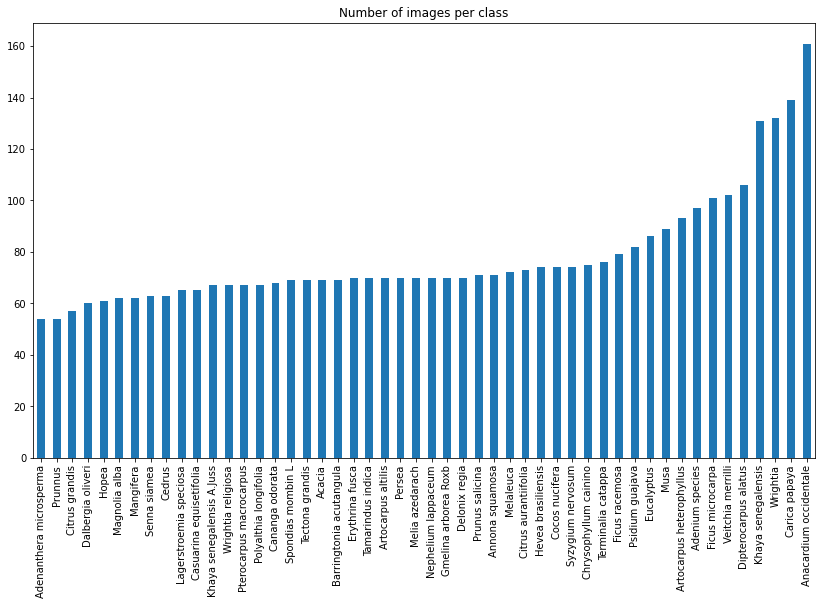

In [12]:
plt.figure(figsize=(14, 8))
train_df.sort_values().plot(kind='bar')
plt.title('Number of images per class')

### Exploring Validation data

In [13]:
count = 0
val_imgs_per_class = {}
for cls in val_ds.class_indices.keys():
    for i in range(len(val_ds.filenames)):
        if cls in val_ds.filenames[i]:
            count += 1
    val_imgs_per_class[cls] = count
    count = 0
val_imgs_per_class

{'Acacia': 33,
 'Adenanthera microsperma': 26,
 'Adenium species': 47,
 'Anacardium occidentale': 78,
 'Annona squamosa': 34,
 'Artocarpus altilis': 34,
 'Artocarpus heterophyllus': 45,
 'Barringtonia acutangula': 33,
 'Cananga odorata': 33,
 'Carica papaya': 68,
 'Casuarina equisetifolia': 32,
 'Cedrus': 30,
 'Chrysophyllum cainino': 36,
 'Citrus aurantiifolia': 35,
 'Citrus grandis': 27,
 'Cocos nucifera': 36,
 'Dalbergia oliveri': 29,
 'Delonix regia': 33,
 'Dipterocarpus alatus': 52,
 'Erythrina fusca': 34,
 'Eucalyptus': 41,
 'Ficus microcarpa': 49,
 'Ficus racemosa': 38,
 'Gmelina arborea Roxb': 33,
 'Hevea brasiliensis': 36,
 'Hopea': 30,
 'Khaya senegalensis': 63,
 'Khaya senegalensis A.Juss': 32,
 'Lagerstroemia speciosa': 31,
 'Magnolia alba': 30,
 'Mangifera': 30,
 'Melaleuca': 35,
 'Melia azedarach': 33,
 'Musa': 43,
 'Nephelium lappaceum': 34,
 'Persea': 33,
 'Polyalthia longifolia': 33,
 'Prunnus': 26,
 'Prunus salicina': 34,
 'Psidium guajava': 40,
 'Pterocarpus macrocar

In [14]:
val_df = pd.Series(val_imgs_per_class)
val_df.describe()

count    50.000000
mean     37.620000
std      10.928133
min      26.000000
25%      33.000000
50%      33.500000
75%      37.750000
max      78.000000
dtype: float64

Text(0.5, 1.0, 'Number of images per class')

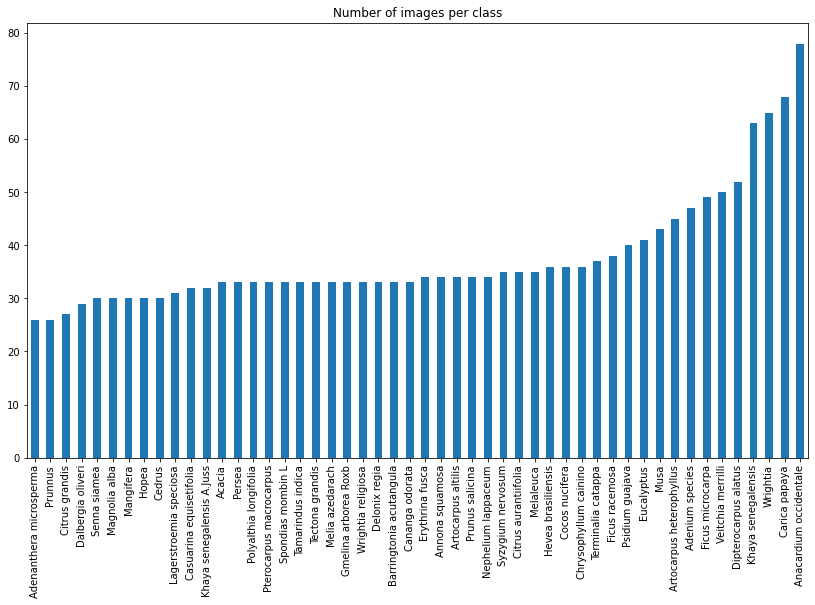

In [15]:
plt.figure(figsize=(14, 8))
(val_df.sort_values()).plot(kind='bar')
plt.title('Number of images per class')

In [16]:
class_names = train_imgs_per_class.keys()
print(class_names)

dict_keys(['Acacia', 'Adenanthera microsperma', 'Adenium species', 'Anacardium occidentale', 'Annona squamosa', 'Artocarpus altilis', 'Artocarpus heterophyllus', 'Barringtonia acutangula', 'Cananga odorata', 'Carica papaya', 'Casuarina equisetifolia', 'Cedrus', 'Chrysophyllum cainino', 'Citrus aurantiifolia', 'Citrus grandis', 'Cocos nucifera', 'Dalbergia oliveri', 'Delonix regia', 'Dipterocarpus alatus', 'Erythrina fusca', 'Eucalyptus', 'Ficus microcarpa', 'Ficus racemosa', 'Gmelina arborea Roxb', 'Hevea brasiliensis', 'Hopea', 'Khaya senegalensis', 'Khaya senegalensis A.Juss', 'Lagerstroemia speciosa', 'Magnolia alba', 'Mangifera', 'Melaleuca', 'Melia azedarach', 'Musa', 'Nephelium lappaceum', 'Persea', 'Polyalthia longifolia', 'Prunnus', 'Prunus salicina', 'Psidium guajava', 'Pterocarpus macrocarpus', 'Senna siamea', 'Spondias mombin L', 'Syzygium nervosum', 'Tamarindus indica', 'Tectona grandis', 'Terminalia catappa', 'Veitchia merrilli', 'Wrightia', 'Wrightia religiosa'])


In [17]:
dict_labels = dict(zip(class_names, list(range(len(class_names)))))
dict_labels

{'Acacia': 0,
 'Adenanthera microsperma': 1,
 'Adenium species': 2,
 'Anacardium occidentale': 3,
 'Annona squamosa': 4,
 'Artocarpus altilis': 5,
 'Artocarpus heterophyllus': 6,
 'Barringtonia acutangula': 7,
 'Cananga odorata': 8,
 'Carica papaya': 9,
 'Casuarina equisetifolia': 10,
 'Cedrus': 11,
 'Chrysophyllum cainino': 12,
 'Citrus aurantiifolia': 13,
 'Citrus grandis': 14,
 'Cocos nucifera': 15,
 'Dalbergia oliveri': 16,
 'Delonix regia': 17,
 'Dipterocarpus alatus': 18,
 'Erythrina fusca': 19,
 'Eucalyptus': 20,
 'Ficus microcarpa': 21,
 'Ficus racemosa': 22,
 'Gmelina arborea Roxb': 23,
 'Hevea brasiliensis': 24,
 'Hopea': 25,
 'Khaya senegalensis': 26,
 'Khaya senegalensis A.Juss': 27,
 'Lagerstroemia speciosa': 28,
 'Magnolia alba': 29,
 'Mangifera': 30,
 'Melaleuca': 31,
 'Melia azedarach': 32,
 'Musa': 33,
 'Nephelium lappaceum': 34,
 'Persea': 35,
 'Polyalthia longifolia': 36,
 'Prunnus': 37,
 'Prunus salicina': 38,
 'Psidium guajava': 39,
 'Pterocarpus macrocarpus': 40,


As the image sample per class is not uniformly distributed, we will create augmented images using **Augmentor pipeline** for those classes which have less image samples than the average so that our model performs well on validation data (as we will have more validation data).

## Dealing with data imbalance

### Creating more data using image augmentation

In [18]:
avg_class = (sum(train_imgs_per_class.values()) + sum(val_imgs_per_class.values()))//50 # Average number of images per class

In [19]:
avg_class

115

In [20]:
for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them
        p = Augmentor.Pipeline("BarkVN-50/BarkVN-50_mendeley/" + folder + '/') # An output folder will be created for each class
        # Point to a directory containing ground truth data.
        # Images with the same file names will be added as ground truth data
        # and augmented in parallel to the original data.
        p.ground_truth("BarkVN-50/BarkVN-50_mendeley/" + folder + '/')
        # Adding operations to the pipeline as normal:
        p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
        p.flip_left_right(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.flip_top_bottom(probability=0.5)
        if train_imgs_per_class[folder] < avg_class:
            p.sample(100-train_imgs_per_class[folder])
        

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Initialised with 102 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Acacia/output.


Processing:   0%|                                                                         | 0/102 [00:00<?, ? Images/s]
                                                                                                                       

102 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDFA0>:   0%|          | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDFA0>:   3%|  | 1/31 [00:00<00:06,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDF10>:   3%|  | 1/31 [00:00<00:06,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C80A0>:   6%|▏ | 2/31 [00:00<00:06,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8DF0>:  10%|▏ | 3/31 [00:00<00:06,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8C10>:  13%|▎ | 4/31 [00:00<00:06,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD760>:  16%|▎ | 5/31 [00:00<00:05,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 80 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Adenanthera microsperma/output.


Processing:   0%|                                                                          | 0/80 [00:00<?, ? Images/s]
                                                                                                                       

80 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/46 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AEE0>:   0%|          | 0/46 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AEE0>:   2%|  | 1/46 [00:00<00:09,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADA60>:   2%|  | 1/46 [00:00<00:09,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8460>:   4%|  | 2/46 [00:00<00:09,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AB80>:   7%|▏ | 3/46 [00:00<00:09,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8EB0>:   9%|▏ | 4/46 [00:00<00:08,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB3D0>:  11%|▏ | 5/46 [00:00<00:08,  4.77 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 144 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Adenium species/output.


Processing:   0%|                                                                         | 0/144 [00:00<?, ? Images/s]
                                                                                                                       

144 ground truth image(s) found.



Executing Pipeline:   0%|                                                                  | 0/3 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6A30>:   0%|           | 0/3 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D67C0>:  33%|█  | 1/3 [00:00<00:00, 32.35 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66E25E0>: 100%|███| 3/3 [00:00<00:00, 71.62 Samples/s]
  6%|████▉                                                                              | 3/50 [00:04<01:00,  1.28s/it]

Initialised with 239 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Anacardium occidentale/output.


  8%|██████▋                                                                            | 4/50 [00:05<00:55,  1.22s/it]

239 ground truth image(s) found.
Initialised with 105 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Annona squamosa/output.


Processing:   0%|                                                                         | 0/105 [00:00<?, ? Images/s]
                                                                                                                       

105 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/29 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2D30>:   0%|          | 0/29 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2EB0>:   3%|  | 1/29 [00:00<00:03,  8.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2EB0>:   7%|▏ | 2/29 [00:00<00:01, 16.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBC70>:   7%|▏ | 2/29 [00:00<00:01, 16.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2610>:  10%|▏ | 3/29 [00:00<00:01, 16.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDBE0>:  14%|▎ | 4/29 [00:00<00:01, 16.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD7C0>:  17%|▎ | 5/29 [00:00<00:01, 16.31 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 104 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Artocarpus altilis/output.


Processing:   0%|                                                                         | 0/104 [00:00<?, ? Images/s]
                                                                                                                       

104 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD3D0>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD3D0>:   3%|  | 1/30 [00:00<00:06,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB790>:   3%|  | 1/30 [00:00<00:06,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB1C0>:   7%|▏ | 2/30 [00:00<00:06,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADF70>:  10%|▏ | 3/30 [00:00<00:06,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8610>:  13%|▎ | 4/30 [00:00<00:06,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8A00>:  17%|▎ | 5/30 [00:00<00:05,  4.27 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 138 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Artocarpus heterophyllus/output.


Processing:   0%|                                                                         | 0/138 [00:00<?, ? Images/s]
                                                                                                                       

138 ground truth image(s) found.



Executing Pipeline:   0%|                                                                  | 0/7 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8040>:   0%|           | 0/7 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6910>:  14%|▍  | 1/7 [00:00<00:00, 10.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6910>:  29%|▊  | 2/7 [00:00<00:00, 19.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EB250>:  29%|▊  | 2/7 [00:00<00:00, 19.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8A60>:  43%|█▎ | 3/7 [00:00<00:00, 19.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EBC40>:  57%|█▋ | 4/7 [00:00<00:00, 19.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8D60>:  71%|██▏| 5/7 [00:00<00:00, 19.66 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 102 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Barringtonia acutangula/output.


Processing:   0%|                                                                         | 0/102 [00:00<?, ? Images/s]
                                                                                                                       

102 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671460>:   0%|          | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD100>:   3%|  | 1/31 [00:00<00:03,  9.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD100>:   6%|▏ | 2/31 [00:00<00:01, 17.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB400>:   6%|▏ | 2/31 [00:00<00:01, 17.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD070>:  10%|▏ | 3/31 [00:00<00:01, 17.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD0D0>:  13%|▎ | 4/31 [00:00<00:01, 17.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2340>:  16%|▎ | 5/31 [00:00<00:01, 17.75 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 101 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Cananga odorata/output.


Processing:   0%|                                                                         | 0/101 [00:00<?, ? Images/s]
                                                                                                                       

101 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/32 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD820>:   0%|          | 0/32 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBF10>:   3%|  | 1/32 [00:00<00:02, 11.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD580>:   6%|▏ | 2/32 [00:00<00:01, 21.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADFD0>:   9%|▏ | 3/32 [00:00<00:00, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6F10>:  12%|▎ | 4/32 [00:00<00:00, 32.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6F10>:  16%|▎ | 5/32 [00:00<00:00, 39.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD8E0>:  16%|▎ | 5/32 [00:00<00:00, 39.17 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 207 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Carica papaya/output.


 20%|████████████████▍                                                                 | 10/50 [00:11<00:42,  1.07s/it]

207 ground truth image(s) found.
Initialised with 97 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Casuarina equisetifolia/output.


Processing:   0%|                                                                          | 0/97 [00:00<?, ? Images/s]
                                                                                                                       

97 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/35 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE50>:   0%|          | 0/35 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE50>:   3%|  | 1/35 [00:00<00:10,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD280>:   3%|  | 1/35 [00:00<00:10,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2580>:   6%|  | 2/35 [00:00<00:09,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBD00>:   9%|▏ | 3/35 [00:00<00:09,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6430>:  11%|▏ | 4/35 [00:00<00:09,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8D60>:  14%|▎ | 5/35 [00:00<00:08,  3.38 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 93 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Cedrus/output.


Processing:   0%|                                                                          | 0/93 [00:00<?, ? Images/s]
                                                                                                                       

93 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/37 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBAC0>:   0%|          | 0/37 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBAC0>:   3%|  | 1/37 [00:00<00:05,  6.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB220>:   3%|  | 1/37 [00:00<00:05,  6.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D66A0>:   5%|  | 2/37 [00:00<00:05,  6.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D66D0>:   8%|▏ | 3/37 [00:00<00:05,  6.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D66D0>:  11%|▏ | 4/37 [00:00<00:02, 15.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6820>:  11%|▏ | 4/37 [00:00<00:02, 15.77 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 111 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Chrysophyllum cainino/output.


Processing:   0%|                                                                         | 0/111 [00:00<?, ? Images/s]
                                                                                                                       

111 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/25 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8610>:   0%|          | 0/25 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66BD340>:   4%|  | 1/25 [00:00<00:02, 10.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66BD340>:   8%|▏ | 2/25 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6310>:   8%|▏ | 2/25 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EB730>:  12%|▏ | 3/25 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8EB0>:  16%|▎ | 4/25 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6C10>:  20%|▍ | 5/25 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 108 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Citrus aurantiifolia/output.


Processing:   0%|                                                                         | 0/108 [00:00<?, ? Images/s]
                                                                                                                       

108 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/27 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66ADC40>:   0%|          | 0/27 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66D6EB0>:   4%|  | 1/27 [00:00<00:02, 11.14 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C6671BB0>:   7%|▏ | 2/27 [00:00<00:01, 21.56 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66BD9D0>:  11%|▏ | 3/27 [00:00<00:00, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EBBB0>:  15%|▎ | 4/27 [00:00<00:00, 40.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EBBB0>:  19%|▎ | 5/27 [00:00<00:00, 46.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C668AB80>:  19%|▎ | 5/27 [00:00<00:00, 46.00 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 84 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Citrus grandis/output.


Processing:   0%|                                                                          | 0/84 [00:00<?, ? Images/s]
                                                                                                                       

84 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/43 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E20A0>:   0%|          | 0/43 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADF70>:   2%|  | 1/43 [00:00<00:03, 12.53 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2340>:   5%|  | 2/43 [00:00<00:01, 24.46 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2D00>:   7%|▏ | 3/43 [00:00<00:01, 36.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2820>:   9%|▏ | 4/43 [00:00<00:01, 34.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2820>:  12%|▏ | 5/43 [00:00<00:00, 42.49 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2460>:  12%|▏ | 5/43 [00:00<00:00, 42.49 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 110 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Cocos nucifera/output.


Processing:   0%|                                                                         | 0/110 [00:00<?, ? Images/s]
                                                                                                                       

110 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBA90>:   0%|          | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBA90>:   4%|  | 1/26 [00:00<00:04,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AC70>:   4%|  | 1/26 [00:00<00:04,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6190>:   8%|▏ | 2/26 [00:00<00:03,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E23D0>:  12%|▏ | 3/26 [00:00<00:03,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D60A0>:  15%|▎ | 4/26 [00:00<00:03,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6C10>:  19%|▍ | 5/26 [00:00<00:03,  6.00 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 89 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Dalbergia oliveri/output.


Processing:   0%|                                                                          | 0/89 [00:00<?, ? Images/s]
                                                                                                                       

89 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/40 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBD30>:   0%|          | 0/40 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBD30>:   2%|  | 1/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB5B0>:   2%|  | 1/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C81C0>:   5%|  | 2/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0430>:   8%|▏ | 3/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB610>:  10%|▏ | 4/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0E20>:  12%|▎ | 5/40 [00:00<00:08,  4.34 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 103 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Delonix regia/output.


Processing:   0%|                                                                         | 0/103 [00:00<?, ? Images/s]
                                                                                                                       

103 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD160>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDBE0>:   3%|  | 1/30 [00:00<00:02, 12.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AF40>:   7%|▏ | 2/30 [00:00<00:01, 16.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AF40>:  10%|▏ | 3/30 [00:00<00:01, 22.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0FA0>:  10%|▏ | 3/30 [00:00<00:01, 22.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F02E0>:  13%|▎ | 4/30 [00:00<00:01, 22.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8F70>:  17%|▎ | 5/30 [00:00<00:01, 22.79 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 158 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Dipterocarpus alatus/output.


Processing:   0%|                                                                         | 0/158 [00:00<?, ? Images/s]
                                                                                                                       

158 ground truth image(s) found.



Executing Pipeline: 0 Samples [00:00, ? Samples/s]
 38%|███████████████████████████████▏                                                  | 19/50 [00:22<00:36,  1.19s/it]

Initialised with 104 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Erythrina fusca/output.


Processing:   0%|                                                                         | 0/104 [00:00<?, ? Images/s]
                                                                                                                       

104 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0700>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0700>:   3%|  | 1/30 [00:00<00:07,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBA90>:   3%|  | 1/30 [00:00<00:07,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C87C0>:   7%|▏ | 2/30 [00:00<00:06,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0850>:  10%|▏ | 3/30 [00:00<00:06,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2400>:  13%|▎ | 4/30 [00:00<00:06,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0FD0>:  17%|▎ | 5/30 [00:00<00:06,  4.11 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 127 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Eucalyptus/output.


Processing:   0%|                                                                         | 0/127 [00:00<?, ? Images/s]
                                                                                                                       

127 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/14 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD430>:   0%|          | 0/14 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB400>:   7%|▏ | 1/14 [00:00<00:01, 11.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0AC0>:  14%|▎ | 2/14 [00:00<00:00, 22.53 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADB20>:  21%|▍ | 3/14 [00:00<00:00, 30.69 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8FD0>:  29%|▌ | 4/14 [00:00<00:00, 39.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8FD0>:  36%|▋ | 5/14 [00:00<00:00, 48.67 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE20>:  36%|▋ | 5/14 [00:00<00:00, 48.67 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 150 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Ficus microcarpa/output.


Processing:   0%|                                                                         | 0/150 [00:00<?, ? Images/s]
                                                                                                                       

150 ground truth image(s) found.



Executing Pipeline: 0 Samples [00:00, ? Samples/s]
 44%|████████████████████████████████████                                              | 22/50 [00:26<00:30,  1.11s/it]

Initialised with 117 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Ficus racemosa/output.


Processing:   0%|                                                                         | 0/117 [00:00<?, ? Images/s]
                                                                                                                       

117 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/21 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8910>:   0%|          | 0/21 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8B80>:   5%|  | 1/21 [00:00<00:01, 11.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EB730>:  10%|▏ | 2/21 [00:00<00:00, 20.67 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66EB730>:  14%|▎ | 3/21 [00:00<00:00, 29.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66F0820>:  14%|▎ | 3/21 [00:00<00:00, 29.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66F0A60>:  19%|▍ | 4/21 [00:00<00:00, 29.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=245x327 at 0x215C66C8D60>:  24%|▍ | 5/21 [00:00<00:00, 29.20 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 103 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Gmelina arborea Roxb/output.


Processing:   0%|                                                                         | 0/103 [00:00<?, ? Images/s]
                                                                                                                       

103 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6160>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6940>:   3%|  | 1/30 [00:00<00:03,  7.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6940>:   7%|▏ | 2/30 [00:00<00:01, 14.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDAC0>:   7%|▏ | 2/30 [00:00<00:01, 14.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C67E7790>:  10%|▏ | 3/30 [00:00<00:01, 14.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBD90>:  13%|▎ | 4/30 [00:00<00:01, 14.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6340>:  17%|▎ | 5/30 [00:00<00:01, 14.22 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 110 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Hevea brasiliensis/output.


Processing:   0%|                                                                         | 0/110 [00:00<?, ? Images/s]
                                                                                                                       

110 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6A90>:   0%|          | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6A90>:   4%|  | 1/26 [00:00<00:05,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD940>:   4%|  | 1/26 [00:00<00:05,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE50>:   8%|▏ | 2/26 [00:00<00:05,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD0A0>:  12%|▏ | 3/26 [00:00<00:05,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD910>:  15%|▎ | 4/26 [00:00<00:04,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6760>:  19%|▍ | 5/26 [00:00<00:04,  4.54 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 91 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Hopea/output.


Processing:   0%|                                                                          | 0/91 [00:00<?, ? Images/s]
                                                                                                                       

91 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/39 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671C40>:   0%|          | 0/39 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671C40>:   3%|  | 1/39 [00:00<00:05,  6.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADCD0>:   3%|  | 1/39 [00:00<00:05,  6.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD910>:   5%|  | 2/39 [00:00<00:05,  6.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E80A0>:   8%|▏ | 3/39 [00:00<00:05,  6.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E80A0>:  10%|▏ | 4/39 [00:00<00:02, 17.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6220>:  10%|▏ | 4/39 [00:00<00:02, 17.41 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 95 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Khaya senegalensis/output.


 54%|████████████████████████████████████████████▎                                     | 27/50 [00:31<00:23,  1.04s/it]

95 ground truth image(s) found.
Initialised with 99 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Khaya senegalensis A.Juss/output.


Processing:   0%|                                                                          | 0/99 [00:00<?, ? Images/s]
                                                                                                                       

99 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E26A0>:   0%|          | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB610>:   3%|  | 1/33 [00:00<00:02, 10.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6EE0>:   6%|  | 2/33 [00:00<00:01, 21.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB2B0>:   9%|▏ | 3/33 [00:00<00:00, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0A60>:  12%|▏ | 4/33 [00:00<00:00, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0A60>:  15%|▎ | 5/33 [00:00<00:00, 38.56 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBB50>:  15%|▎ | 5/33 [00:00<00:00, 38.56 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 96 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Lagerstroemia speciosa/output.


Processing:   0%|                                                                          | 0/96 [00:00<?, ? Images/s]
                                                                                                                       

96 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/35 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD790>:   0%|          | 0/35 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD790>:   3%|  | 1/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD9D0>:   3%|  | 1/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671CA0>:   6%|  | 2/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671190>:   9%|▏ | 3/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDE20>:  11%|▏ | 4/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBE80>:  14%|▎ | 5/35 [00:00<00:03,  8.57 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 92 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Magnolia alba/output.


Processing:   0%|                                                                          | 0/92 [00:00<?, ? Images/s]
                                                                                                                       

92 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/38 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E21C0>:   0%|          | 0/38 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E21C0>:   3%|  | 1/38 [00:00<00:08,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6DC0>:   3%|  | 1/38 [00:00<00:08,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD220>:   5%|  | 2/38 [00:00<00:08,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBB50>:   8%|▏ | 3/38 [00:00<00:07,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66716D0>:  11%|▏ | 4/38 [00:00<00:07,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6340>:  13%|▎ | 5/38 [00:00<00:07,  4.44 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 92 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Mangifera/output.


Processing:   0%|                                                                          | 0/92 [00:00<?, ? Images/s]
                                                                                                                       

92 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/38 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDAF0>:   0%|          | 0/38 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDAF0>:   3%|  | 1/38 [00:00<00:10,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6760>:   3%|  | 1/38 [00:00<00:10,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB340>:   5%|  | 2/38 [00:00<00:10,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD8B0>:   8%|▏ | 3/38 [00:00<00:10,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668ADF0>:  11%|▏ | 4/38 [00:00<00:10,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB550>:  13%|▎ | 5/38 [00:00<00:09,  3.39 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 107 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Melaleuca/output.


Processing:   0%|                                                                         | 0/107 [00:00<?, ? Images/s]
                                                                                                                       

107 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/28 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F08E0>:   0%|          | 0/28 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AB20>:   4%|  | 1/28 [00:00<00:02, 12.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AD60>:   7%|▏ | 2/28 [00:00<00:01, 23.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2A90>:  11%|▏ | 3/28 [00:00<00:01, 22.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2A90>:  14%|▎ | 4/28 [00:00<00:00, 29.28 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBC10>:  14%|▎ | 4/28 [00:00<00:00, 29.28 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AD30>:  18%|▎ | 5/28 [00:00<00:00, 29.28 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 103 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Melia azedarach/output.


Processing:   0%|                                                                         | 0/103 [00:00<?, ? Images/s]
                                                                                                                       

103 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6160>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6160>:   3%|  | 1/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6220>:   3%|  | 1/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6C70>:   7%|▏ | 2/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E21C0>:  10%|▏ | 3/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2A60>:  13%|▎ | 4/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0EB0>:  17%|▎ | 5/30 [00:00<00:03,  8.15 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 132 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Musa/output.


Processing:   0%|                                                                         | 0/132 [00:00<?, ? Images/s]
                                                                                                                       

132 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/11 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2D60>:   0%|          | 0/11 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2D60>:   9%|▏ | 1/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D66D0>:   9%|▏ | 1/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2610>:  18%|▎ | 2/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2400>:  27%|▌ | 3/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E24F0>:  36%|▋ | 4/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668ABB0>:  45%|▉ | 5/11 [00:00<00:01,  5.66 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 104 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Nephelium lappaceum/output.


Processing:   0%|                                                                         | 0/104 [00:00<?, ? Images/s]
                                                                                                                       

104 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADC10>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADC10>:   3%|  | 1/30 [00:00<00:08,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AEB0>:   3%|  | 1/30 [00:00<00:08,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADBB0>:   7%|▏ | 2/30 [00:00<00:07,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADB20>:  10%|▏ | 3/30 [00:00<00:07,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668A100>:  13%|▎ | 4/30 [00:00<00:07,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD0D0>:  17%|▎ | 5/30 [00:00<00:06,  3.62 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 103 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Persea/output.


Processing:   0%|                                                                         | 0/103 [00:00<?, ? Images/s]
                                                                                                                       

103 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0130>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0130>:   3%|  | 1/30 [00:00<00:03,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0250>:   3%|  | 1/30 [00:00<00:03,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0400>:   7%|▏ | 2/30 [00:00<00:03,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0F10>:  10%|▏ | 3/30 [00:00<00:03,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0700>:  13%|▎ | 4/30 [00:00<00:02,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E24C0>:  17%|▎ | 5/30 [00:00<00:02,  8.80 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 100 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Polyalthia longifolia/output.


Processing:   0%|                                                                         | 0/100 [00:00<?, ? Images/s]
                                                                                                                       

100 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C85E0>:   0%|          | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8D30>:   3%|  | 1/33 [00:00<00:02, 13.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8A60>:   6%|  | 2/33 [00:00<00:01, 23.87 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8E50>:   9%|▏ | 3/33 [00:00<00:00, 34.98 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8550>:  12%|▏ | 4/33 [00:00<00:00, 45.06 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2280>:  15%|▎ | 5/33 [00:00<00:00, 38.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2280>:  18%|▎ | 6/33 [00:00<00:00, 45.23 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 80 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Prunnus/output.


Processing:   0%|                                                                          | 0/80 [00:00<?, ? Images/s]
                                                                                                                       

80 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/46 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB490>:   0%|          | 0/46 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB490>:   2%|  | 1/46 [00:00<00:07,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBA30>:   2%|  | 1/46 [00:00<00:07,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB610>:   4%|  | 2/46 [00:00<00:07,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6D00>:   7%|▏ | 3/46 [00:00<00:07,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AB80>:   9%|▏ | 4/46 [00:00<00:07,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD0D0>:  11%|▏ | 5/46 [00:00<00:06,  5.93 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 105 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Prunus salicina/output.


Processing:   0%|                                                                         | 0/105 [00:00<?, ? Images/s]
                                                                                                                       

105 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/29 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8DC0>:   0%|          | 0/29 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8DC0>:   3%|  | 1/29 [00:00<00:03,  7.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6490>:   3%|  | 1/29 [00:00<00:03,  7.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671BB0>:   7%|▏ | 2/29 [00:00<00:03,  7.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671BB0>:  10%|▏ | 3/29 [00:00<00:02, 12.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671130>:  10%|▏ | 3/29 [00:00<00:02, 12.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D66D0>:  14%|▎ | 4/29 [00:00<00:01, 12.82 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 122 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Psidium guajava/output.


Processing:   0%|                                                                         | 0/122 [00:00<?, ? Images/s]
                                                                                                                       

122 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/18 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD670>:   0%|          | 0/18 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD670>:   6%|  | 1/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDA30>:   6%|  | 1/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2C40>:  11%|▏ | 2/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6A60>:  17%|▎ | 3/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2610>:  22%|▍ | 4/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADEB0>:  28%|▌ | 5/18 [00:00<00:01,  9.64 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 100 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Pterocarpus macrocarpus/output.


Processing:   0%|                                                                         | 0/100 [00:00<?, ? Images/s]
                                                                                                                       

100 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AA60>:   0%|          | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AA60>:   3%|  | 1/33 [00:00<00:06,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2D30>:   3%|  | 1/33 [00:00<00:06,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AF70>:   6%|  | 2/33 [00:00<00:05,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2B80>:   9%|▏ | 3/33 [00:00<00:05,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66E2DC0>:  12%|▏ | 4/33 [00:00<00:05,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADF40>:  15%|▎ | 5/33 [00:00<00:05,  5.17 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 93 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Senna siamea/output.


Processing:   0%|                                                                          | 0/93 [00:00<?, ? Images/s]
                                                                                                                       

93 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/37 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6850>:   0%|          | 0/37 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6850>:   3%|  | 1/37 [00:00<00:07,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6715280>:   3%|  | 1/37 [00:00<00:07,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66F0850>:   5%|  | 2/37 [00:00<00:07,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD130>:   8%|▏ | 3/37 [00:00<00:07,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671190>:  11%|▏ | 4/37 [00:00<00:07,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD190>:  14%|▎ | 5/37 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 102 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Spondias mombin L/output.


Processing:   0%|                                                                         | 0/102 [00:00<?, ? Images/s]
                                                                                                                       

102 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADFD0>:   0%|          | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB0D0>:   3%|  | 1/31 [00:00<00:03,  9.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB0D0>:   6%|▏ | 2/31 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EB640>:   6%|▏ | 2/31 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8460>:  10%|▏ | 3/31 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6F10>:  13%|▎ | 4/31 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D68E0>:  16%|▎ | 5/31 [00:00<00:01, 19.47 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 109 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Syzygium nervosum/output.


Processing:   0%|                                                                         | 0/109 [00:00<?, ? Images/s]
                                                                                                                       

109 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDA00>:   0%|          | 0/26 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDA00>:   4%|  | 1/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AEE0>:   4%|  | 1/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AB80>:   8%|▏ | 2/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8250>:  12%|▏ | 3/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C85E0>:  15%|▎ | 4/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6850>:  19%|▍ | 5/26 [00:00<00:02,  8.95 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 103 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Tamarindus indica/output.


Processing:   0%|                                                                         | 0/103 [00:00<?, ? Images/s]
                                                                                                                       

103 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE50>:   0%|          | 0/30 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADE50>:   3%|  | 1/30 [00:00<00:06,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668AA60>:   3%|  | 1/30 [00:00<00:06,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8D60>:   7%|▏ | 2/30 [00:00<00:06,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8310>:  10%|▏ | 3/30 [00:00<00:06,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD8E0>:  13%|▎ | 4/30 [00:00<00:06,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD550>:  17%|▎ | 5/30 [00:00<00:05,  4.23 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 102 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Tectona grandis/output.


Processing:   0%|                                                                         | 0/102 [00:00<?, ? Images/s]
                                                                                                                       

102 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671190>:   0%|          | 0/31 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C6671190>:   3%|  | 1/31 [00:00<00:05,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6940>:   3%|  | 1/31 [00:00<00:05,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66D6730>:   6%|▏ | 2/31 [00:00<00:04,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66EBBB0>:  10%|▏ | 3/31 [00:00<00:04,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD6D0>:  13%|▎ | 4/31 [00:00<00:04,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD6D0>:  16%|▎ | 5/31 [00:00<00:01, 21.35 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 113 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Terminalia catappa/output.


Processing:   0%|                                                                         | 0/113 [00:00<?, ? Images/s]
                                                                                                                       

113 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/24 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD400>:   0%|          | 0/24 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD400>:   4%|  | 1/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD910>:   4%|  | 1/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD820>:   8%|▏ | 2/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BDA00>:  12%|▎ | 3/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66ADCA0>:  17%|▎ | 4/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66BD130>:  21%|▍ | 5/24 [00:00<00:02,  8.64 Samples/s]
Processing <PIL.Image.Image image mode=

Initialised with 152 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Veitchia merrilli/output.


Processing:   0%|                                                                         | 0/152 [00:00<?, ? Images/s]
                                                                                                                       

152 ground truth image(s) found.



Executing Pipeline: 0 Samples [00:00, ? Samples/s]
 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:59<00:02,  1.23s/it]

Initialised with 97 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Wrightia/output.


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:00<00:01,  1.12s/it]

97 ground truth image(s) found.
Initialised with 100 image(s) found.
Output directory set to BarkVN-50/BarkVN-50_mendeley/Wrightia religiosa/output.


Processing:   0%|                                                                         | 0/100 [00:00<?, ? Images/s]
                                                                                                                       

100 ground truth image(s) found.



Executing Pipeline:   0%|                                                                 | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668A9A0>:   0%|          | 0/33 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668A9A0>:   3%|  | 1/33 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66CF1C0>:   3%|  | 1/33 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8E50>:   6%|  | 2/33 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66C8280>:   9%|▏ | 3/33 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C668A040>:  12%|▏ | 4/33 [00:00<00:06,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x404 at 0x215C66AD1C0>:  15%|▎ | 5/33 [00:00<00:05,  4.71 Samples/s]
Processing <PIL.Image.Image image mode=

**Reference for the augmentation technique:** https://github.com/mdbloice/Augmentor/blob/master/notebooks/Per_Class_Augmentation_Strategy.ipynb

#### Moving augmented images from output folders to the original class folders

In [21]:
import shutil
import os
import glob
count = 0
for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")): 
    ## path to source directory
    files = os.listdir("BarkVN-50/BarkVN-50_mendeley/" + folder + "/output")
    for image in files:
        image = cv2.imread("BarkVN-50/BarkVN-50_mendeley/" + folder + "/output/" + image)
        count +=1
        # moving images from output folders to respective image class folder
        cv2.imwrite("BarkVN-50/BarkVN-50_mendeley/" + folder + "/"+'IMG_AUG_{}.JPG'.format(count), image, [int(cv2.IMWRITE_JPEG_QUALITY), 95]) 
    count=0
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


#### Deleting the output folders

In [22]:
for folder in tqdm(os.listdir("BarkVN-50/BarkVN-50_mendeley/")): 
# Remove the Directory
    path = "BarkVN-50/BarkVN-50_mendeley/" + folder + "/output"
    shutil.rmtree(path)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.07it/s]


**Creating custom function to load the dataset**

In [23]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them
        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels


### Loading the dataset using the dataset function

In [24]:
images, labels = dataset('BarkVN-50/BarkVN-50_mendeley/')    # Loading the dataset
images, labels = shuffle(images, labels, random_state=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


In [25]:
labels = keras.utils.to_categorical(labels, 50) # Converting labels to (_, 50) shape for model training

###  Splitting the dataset into train and validation sets

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

In [28]:
print( x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(5691, 150, 150, 3)
(2439, 150, 150, 3)
(5691, 50)
(2439, 50)


In [29]:
print(np.mean(x_train))
print(np.median(x_train))

0.474525
0.45490196


In [30]:
print(np.mean(x_val))
print(np.median(x_val))

0.4739313
0.45490196


#### We can observe that both training and validation dataset are quite well distributed.

## Model Building

In [14]:
base_model = keras.applications.ResNet101V2(include_top=False, input_shape=(150,150,3), weights="imagenet")  # Transfer learning
base_model.trainable = False   # Setting the training of resnet layers to false to fit our data

In [24]:
model_2= keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(50, activation='softmax')
])

In [25]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 50)                102450    
                                                                 
Total params: 42,729,010
Trainable params: 102,450
Non-trainable params: 42,626,560
_________________________________________________________________


In [78]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
history_2 = model_2.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/20
178/178 [==============================] - 1127s 6s/step - loss: 1.9476 - accuracy: 0.5120 - val_loss: 1.0369 - val_accuracy: 0.7331
Epoch 2/20
178/178 [==============================] - 673s 4s/step - loss: 0.8277 - accuracy: 0.7900 - val_loss: 0.7558 - val_accuracy: 0.8089
Epoch 3/20
178/178 [==============================] - 639s 4s/step - loss: 0.5837 - accuracy: 0.8545 - val_loss: 0.6244 - val_accuracy: 0.8434
Epoch 4/20
178/178 [==============================] - 614s 3s/step - loss: 0.4479 - accuracy: 0.8923 - val_loss: 0.5639 - val_accuracy: 0.8573
Epoch 5/20
178/178 [==============================] - 615s 3s/step - loss: 0.3656 - accuracy: 0.9188 - val_loss: 0.5238 - val_accuracy: 0.8692
Epoch 6/20
178/178 [==============================] - 615s 3s/step - loss: 0.3078 - accuracy: 0.9318 - val_loss: 0.4784 - val_accuracy: 0.8848
Epoch 7/20
178/178 [==============================] - 617s 3s/step - loss: 0.2617 - accuracy: 0.9436 - val_loss: 0.4668 - val_accuracy: 0.886

In [80]:
preds_2 = model_2.evaluate(x_val, y_val, batch_size=32)
print ("Loss = " + str(preds[0]))
print ("Valiadtion Accuracy = " + str(preds[1]))

77/77 [==============================] - 184s 2s/step - loss: 0.3872 - accuracy: 0.9049
Loss = 0.626278817653656
Valiadtion Accuracy = 0.8720787167549133


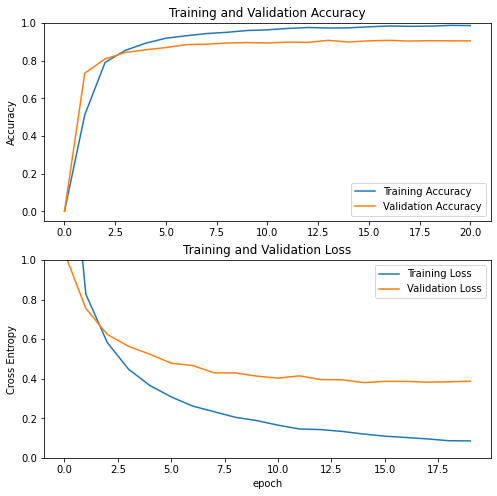

In [81]:
acc = [0.] + history_2.history['accuracy']
val_acc = [0.] + history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Model 2 performs better than model 1, so we will choose model 2 as our final model.

### Classification report

In [102]:
pred=model_2.predict(x_val) 
outcomes=np.argmax(pred,axis=1)

77/77 [==============================] - 191s 2s/step


In [99]:
from sklearn.metrics import classification_report

In [103]:
print(classification_report(np.where(y_val == 1)[1], outcomes, target_names=class_names))

                           precision    recall  f1-score   support

                   Acacia       0.95      0.98      0.96        56
  Adenanthera microsperma       0.87      0.92      0.89        49
          Adenium species       1.00      1.00      1.00        43
   Anacardium occidentale       0.94      0.96      0.95        68
          Annona squamosa       0.96      0.92      0.94        52
       Artocarpus altilis       1.00      1.00      1.00        50
 Artocarpus heterophyllus       0.94      0.88      0.91        57
  Barringtonia acutangula       0.89      0.96      0.92        49
          Cananga odorata       0.96      0.81      0.88        57
            Carica papaya       1.00      0.97      0.98        65
  Casuarina equisetifolia       0.88      0.94      0.91        48
                   Cedrus       0.96      0.98      0.97        52
    Chrysophyllum cainino       0.96      1.00      0.98        51
     Citrus aurantiifolia       0.98      0.95      0.97     

#### We can observe that our model performs well on average.